In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
import matplotlib
#matplotlib.use('nbAgg')
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [2]:
!! which python

['/home/admin/pyenvs/p37_s5p/bin/python']

In [3]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import cartopy.crs as ccrs
from pathlib import Path
from datetime import datetime
from pprint import pprint, pformat
import geojsoncontour

In [4]:
import sys
sys.path.append('./satpull')
from s5p import S5PSession, ProductType, ProcessingMode, print_product_summary, TURKEY_LATLON_BOUNDS
from s5p_cities import cities

In [5]:
s5p_session = S5PSession()

In [6]:
s5p_session.login()

In [7]:
print(s5p_session.login_http_status)

200 OK


In [8]:
product_type = ProductType.CO
processing_mode = ProcessingMode.NRT
bounds = cities['marmara']
lat1, lat2, lon1, lon2 = bounds
refresh_period = 1

In [9]:
products = s5p_session.query(limit=1, bounds=bounds, product_type=product_type, processing_mode=processing_mode)

Login status OK
Querying 
Fetched 1 out of 25 products


In [10]:
for product in products['products']:
    print_product_summary(product)

Date : 2020-03-24T11:08:44.000Z
Size : 18.5 MB
UUID: a0b76ddc-26f2-491e-8c8e-f9ead0dcf769
https://s5phub.copernicus.eu/dhus/odata/v1/Products('a0b76ddc-26f2-491e-8c8e-f9ead0dcf769')/$value
Identifier: S5P_NRTI_L2__CO_____20200324T110850_20200324T111350_12670_01_010302_20200324T114834
offline: False
productType: L2__CO____


In [11]:
uuid = products['products'][0]['uuid']
identifier = products['products'][0]['identifier']
target_filepath = s5p_session.download_product(uuid=uuid, output_folder=Path('/tmp/'), refresh_period=refresh_period)

Login status OK
Matched UUID a0b76ddc-26f2-491e-8c8e-f9ead0dcf769 to product Date : 2020-03-24T11:08:44.000Z
Size : 18.5 MB
UUID: a0b76ddc-26f2-491e-8c8e-f9ead0dcf769
https://s5phub.copernicus.eu/dhus/odata/v1/Products('a0b76ddc-26f2-491e-8c8e-f9ead0dcf769')/$value
Identifier: S5P_NRTI_L2__CO_____20200324T110850_20200324T111350_12670_01_010302_20200324T114834
offline: False
productType: L2__CO____
Target file exists at /tmp/S5P_NRTI_L2__CO_____20200324T110850_20200324T111350_12670_01_010302_20200324T114834.nc. Use overwrite flag if you want to download again


In [12]:
var_name = product_type.var_name()
print(var_name)

carbonmonoxide_total_column


In [13]:
rootgrp = netcdf_dataset(target_filepath, 'r');
print(rootgrp.groups)

{'PRODUCT': <class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(372), ground_pixel(215), corner(4), time(1), layer(50)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 layer(layer), int32 delta_time(time,scanline), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), float32 carbonmonoxide_total_column(time,scanline,ground_pixel), float32 carbonmonoxide_total_column_precision(time,scanline,ground_pixel)
    groups: SUPPORT_DATA, 'METADATA': <class 'netCDF4._netCDF4.Group'>
group /METADATA:
    dimensions(sizes): 
    variables(dimensions): 
    groups: QA_STATISTICS, ALGORITHM_SETTINGS, GRANULE_DESCRIPTION, ISO_METADATA, EOP_METADATA, ESA_METADATA}


In [14]:
product_grp = rootgrp['PRODUCT']
print(product_grp)

<class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(372), ground_pixel(215), corner(4), time(1), layer(50)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 layer(layer), int32 delta_time(time,scanline), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), float32 carbonmonoxide_total_column(time,scanline,ground_pixel), float32 carbonmonoxide_total_column_precision(time,scanline,ground_pixel)
    groups: SUPPORT_DATA


In [15]:
print(product_grp[var_name])

<class 'netCDF4._netCDF4.Variable'>
float32 carbonmonoxide_total_column(time, scanline, ground_pixel)
    units: mol m-2
    standard_name: atmosphere_mole_content_of_carbon_monoxide
    long_name: Vertically integrated CO column
    coordinates: longitude latitude
    ancillary_variables: carbonmonoxide_total_column_precision
    multiplication_factor_to_convert_to_molecules_percm2: 6.022141e+19
    _FillValue: 9.96921e+36
path = /PRODUCT
unlimited dimensions: 
current shape = (1, 372, 215)
filling on


In [16]:
plotme_nc = product_grp[var_name]
lats_nc = product_grp['latitude']
lons_nc = product_grp['longitude']

plotme_np = plotme_nc[:]
lats_np = lats_nc[:]
lons_np = lons_nc[:]

plotme_np = plotme_np[0,:,:]
lats_np = lats_np[0,:,:]
lons_np = lons_np[0,:,:]

In [17]:
for i, x in enumerate([plotme_np, lats_np, lons_np, ]):
    print(f'x[{i}] is {x.__class__} of shape {x.shape}')

x[0] is <class 'numpy.ma.core.MaskedArray'> of shape (372, 215)
x[1] is <class 'numpy.ma.core.MaskedArray'> of shape (372, 215)
x[2] is <class 'numpy.ma.core.MaskedArray'> of shape (372, 215)


In [18]:
lat1_mask = lats_np>=lat1
lat2_mask = lats_np<=lat2
lon1_mask = lons_np>=lon1
lon2_mask = lons_np<=lon2
bounds_mask = lat1_mask & lat2_mask & lon1_mask & lon2_mask
plotme_np.mask = ~bounds_mask | plotme_np.mask
plotme_np.mask = plotme_np.mask | (plotme_np==plotme_nc._FillValue)
lats_np.mask = plotme_np.mask
lons_np.mask = plotme_np.mask

In [19]:
print(plotme_np.shape)
plotme_np = plotme_np[:, ~np.all(plotme_np.mask, axis=0)]
plotme_np = plotme_np[~np.all(plotme_np.mask, axis=1), :]
print(plotme_np.shape, end='\n-\n')

print(lats_np.shape)
lats_np = lats_np[:, ~np.all(lats_np.mask, axis=0)]
lats_np = lats_np[~np.all(lats_np.mask, axis=1), :]
print(lats_np.shape, end='\n-\n')

print(lons_np.shape)
lons_np = lons_np[:, ~np.all(lons_np.mask, axis=0)]
lons_np = lons_np[~np.all(lons_np.mask, axis=1), :]
print(lons_np.shape, end='\n-\n')

print(plotme_np.count())
print(lats_np.count())
print(lons_np.count())

(372, 215)
(87, 83)
-
(372, 215)
(87, 83)
-
(372, 215)
(87, 83)
-
2238
2238
2238


In [20]:
data = np.ndarray(shape=(plotme_np.count(), 3))
data[:, 0] = lats_np.compressed()
data[:, 1] = lons_np.compressed()
data[:, 2] = plotme_np.compressed()
data_aslist = data.tolist()
import json
json.dumps(data_aslist)

'[[37.99957275390625, 31.135709762573242, 0.02751326560974121], [38.020111083984375, 31.328683853149414, 0.02695525251328945], [38.03018569946289, 31.426551818847656, 0.028299950063228607], [38.04012680053711, 31.5253849029541, 0.027158530429005623], [38.049930572509766, 31.62521743774414, 0.029640985652804375], [38.07851028442383, 31.931055068969727, 0.02882568910717964], [38.08774948120117, 32.03524398803711, 0.02527756616473198], [38.0589599609375, 31.21871566772461, 0.025189312174916267], [38.06916809082031, 31.315719604492188, 0.02445441298186779], [38.07924270629883, 31.413654327392578, 0.02614419534802437], [38.08918380737305, 31.512554168701172, 0.02726307325065136], [38.09899139404297, 31.61245346069336, 0.029064897447824478], [38.118186950683594, 31.81538963317871, 0.028677552938461304], [38.12757110595703, 31.918500900268555, 0.02689623460173607], [38.13681411743164, 32.02275848388672, 0.026718121021986008], [37.99897766113281, 30.279754638671875, 0.032540734857320786], [38.

In [21]:
print('Overall')
print(f'Min-Max {plotme_nc[:].min():.6f}-{plotme_nc[:].max():.6f}')
print(f'Mean-Var {plotme_nc[:].mean():.6f}-{plotme_nc[:].var():.6f}')
minval = plotme_np.min()
maxval = plotme_np.max()
meanval = plotme_np.mean()
varval = plotme_np.var()
print('Masked')
print(f'Min-Max {minval:.6f}-{maxval:.6f}')
print(f'Mean-Var {meanval:.6f}-{varval:.6f}')

Overall
Min-Max 0.012266-0.069337
Mean-Var 0.034737-0.000011
Masked
Min-Max 0.021404-0.052248
Mean-Var 0.034070-0.000014


In [22]:
plotme_final = plotme_np.copy()
plotme_final = (plotme_final)

minval = plotme_final.min()*1.05
maxval = plotme_final.max()*0.95
meanval = plotme_final.mean()
varval = plotme_final.var()

print('PostProcessed')
print(f'Min-Max {minval:.6f}-{maxval:.6f}')
print(f'Mean-Var {meanval:.6f}-{varval:.6f}')

PostProcessed
Min-Max 0.022474-0.049636
Mean-Var 0.034070-0.000014


In [34]:
vmin = minval*1.0
vmax = maxval*1.0
levels = 16

In [35]:
validity_start = rootgrp['METADATA']['ESA_METADATA']['earth_explorer_header']['fixed_header']['validity_period'].Validity_Start
validity_stop = rootgrp['METADATA']['ESA_METADATA']['earth_explorer_header']['fixed_header']['validity_period'].Validity_Stop
description = rootgrp['METADATA']['ESA_METADATA']['earth_explorer_header']['fixed_header'].File_Description
print(f'File_Description: {description}')
cut_from = description.find('observed')
description = description[:cut_from if cut_from>0 else len(description)]
long_name = plotme_nc.long_name
if not description:
    description = long_name
print(f'long_name: {long_name}')

File_Description: Carbon monoxide column with a spatial resolution of 7x7km2 observed at about 13:30 local solar time from spectra measured by TROPOMI
long_name: Vertically integrated CO column


### Filled Contour Plot

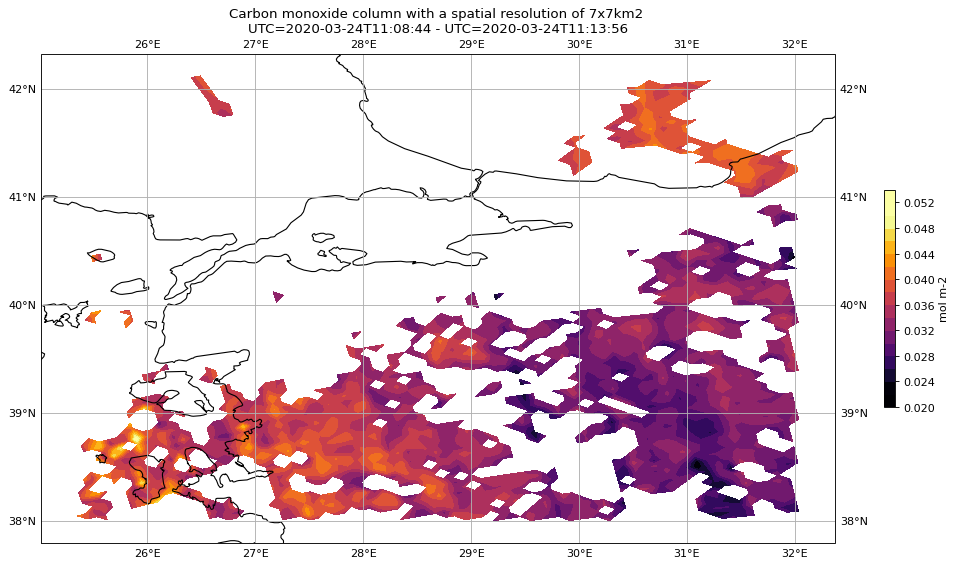

In [36]:
fig=plt.figure(figsize=(16, 18), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((lon1-0.5, lon2+0.5, lat1-0.5, lat2+0.5))
plt.title(f'{description}\n{validity_start} - {validity_stop}')
cs = plt.contourf(lons_np, lats_np, plotme_final, levels, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap="inferno")
ax.coastlines()
ax.gridlines(draw_labels=True)
# ax.stock_img()
cbar = fig.colorbar(cs, ax=ax, shrink=0.2)
cbar.ax.set_ylabel(plotme_nc.units)
# Add the contour line levels to the colorbar
plt.show()

In [33]:
# Convert matplotlib contourf to geojson
identifier = products['products'][0]['identifier']
geojson_filepath = f'{identifier}.geojson'
geojsoncontour.contourf_to_geojson(
    contourf=cs,
    min_angle_deg=3.0,
    ndigits=3,
    stroke_width=2,
    fill_opacity=0.5,
    geojson_filepath=geojson_filepath,
)

In [29]:
with open(geojson_filepath, 'r') as geojson:
    print(geojson.read())

{"features":[{"geometry":{"coordinates":[[[[30.418,38.168],[30.418,38.169],[30.418,38.168]]],[[[31.347,38.323],[31.349,38.324],[31.351,38.325],[31.348,38.326],[31.347,38.323]]],[[[31.41,38.479],[31.413,38.48],[31.409,38.482],[31.412,38.483],[31.408,38.486],[31.41,38.479]]],[[[31.108,38.474],[31.144,38.505],[31.107,38.551],[31.085,38.559],[31.072,38.548],[31.108,38.474]]],[[[29.588,38.822],[29.588,38.822],[29.588,38.822],[29.588,38.822],[29.588,38.822]]],[[[31.97,40.422],[31.995,40.436],[31.988,40.465],[31.97,40.422]]]],"type":"MultiPolygon"},"properties":{"fill":"#000004","fill-opacity":0.5,"stroke":"#000004","stroke-opacity":1,"stroke-width":2,"title":"0.02 "},"type":"Feature"},{"geometry":{"coordinates":[[[[31.329,38.02],[31.405,38.028],[31.453,38.033],[31.525,38.04],[31.559,38.043],[31.553,38.093],[31.518,38.14],[31.526,38.191],[31.529,38.216],[31.487,38.187],[31.375,38.226],[31.296,38.254],[31.279,38.217],[31.277,38.214],[31.273,38.216],[31.169,38.244],[31.15,38.203],[31.107,38.106